In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import os
from datetime import datetime
from scipy.optimize import curve_fit

from modelGPT.constants import (
    ALL_FEATURES, GROUND_TRUTH_CSV, MODEL_NAME_COL, DATASET_COL, PRED_TARGET
)

sns.set_palette('colorblind')
df = pd.read_csv(GROUND_TRUTH_CSV)

In [2]:
name_order = {'imagenet1k':'Imagenet','sun397':'SUN397', 'flowers':'flowers102', 'caltech101':'CalTech101',
              'pets':'Oxford Pets','cifar100':'CIFAR100', 
          'cars':'Stanford Cars','stl10':'stl10','voc2007':'VOC2007','resisc45':'resisc45',
              'eurosat':'euroSAT','fgvc_aircraft':'FGVC aircraft', 'gtsrb':'GTSRB',
          'kitti_closest_vehicle_distance':'KITTI','country211':'country211', 'dmlab':'DMLab', 'svhn':'SVHN','fer2013':'FER2013','diabetic_retinopathy':'Retinopathy',
          'clevr_closest_object_distance':'CLEVR-DISTANCE','clevr_count_all':'CLEVR-COUNT','mnist':'MNIST','dtd':'DTD', 'pcam':'Pcam', 'renderedsst2':'renderedsst2'
             }

In [3]:
translation_dict = {
    'coca_ViT-B-32 laion2b_s13b_b90k': 'CoCa-ViT-B/32, L2b-c',
    'coca_ViT-B-32 mscoco_finetuned_laion2b_s13b_b90k': 'CoCa-ViT-B/32, L2b-c + coco',
    'coca_ViT-L-14 laion2b_s13b_b90k': 'CoCa-ViT-L/14, L2b-c',
    'coca_ViT-L-14 mscoco_finetuned_laion2b_s13b_b90k': 'CoCa-ViT-L/14, L2b-c + coco',
    'convnext_base laion400m_s13b_b51k': 'ConvNEXT-B, L400m-c',
    'convnext_base_w laion2b_s13b_b82k': 'ConvNEXT-BW, L2b-d',
    'convnext_base_w laion2b_s13b_b82k_augreg': 'ConvNEXT-BW, L2b-e',
    'convnext_base_w laion_aesthetic_s13b_b82k': 'ConvNEXT-BW, L2b-f',
    'convnext_base_w_320 laion_aesthetic_s13b_b82k': 'ConvNEXT-BW-320, L2b-f',
    'convnext_base_w_320 laion_aesthetic_s13b_b82k_augreg': 'ConvNEXT-BW-320, L2b-g',
    'convnext_large_d laion2b_s26b_b102k_augreg': 'ConvNEXT-LD, L2b-h',
    'convnext_large_d_320 laion2b_s29b_b131k_ft': 'ConvNEXT-LD-320, L2b-i',
    'convnext_large_d_320 laion2b_s29b_b131k_ft_soup': 'ConvNEXT-LD-320, L2b-j',
    'RN50 openai': 'RN50, WIT',
    'RN101 openai': 'RN101, WIT',
    'RN50x4 openai': 'RN50x4, WIT',
    'RN50x16 openai': 'RN50x16, WIT',
    'RN50x64 openai': 'RN50x64, WIT',
    'ViT-B-32 openai': 'ViT-B/32, WIT',
    'ViT-B-16 openai': 'ViT-B/16, WIT',
    'ViT-L-14 openai': 'ViT-L/14, WIT',
    'ViT-L-14-336 openai': 'ViT-L/14-336, WIT',
    'ViT-B-16 laion400m_e32': 'ViT-B/16, L400m-a',
    'ViT-B-16-plus-240 laion400m_e32': 'ViT-B/16-240, L400m-a',
    'ViT-B-32 laion2b_e16': 'ViT-B/32, L2b-c',
    'ViT-B-32 laion2b_s34b_b79k': 'ViT-B/32, L2b-b',
    'ViT-B-32 laion400m_e31': 'ViT-B/32, L400m-b',
    'ViT-B-32 laion400m_e32': 'ViT-B/32, L400m-a',
    'ViT-B-32-quickgelu laion400m_e32': 'ViT-B/32, L400m-a2',
    'ViT-H-14 laion2b_s32b_b79k': 'ViT-H/14, L2b-b',
    'ViT-L-14 laion2b_s32b_b82k': 'ViT-L/14, L2b-b',
    'ViT-L-14 laion400m_e31': 'ViT-L/14, L400m-b',
    'ViT-L-14 laion400m_e32': 'ViT-L/14, L400m-a',
    'ViT-g-14 laion2b_s12b_b42k': 'ViT-G/14, L2b-a',
    'ViT-g-14 laion2b_s34b_b88k': 'ViT-G/14, L2b-b'
}


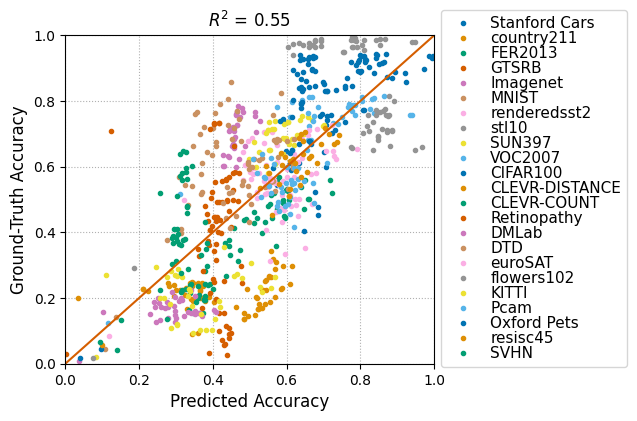

In [4]:

PRED_TARGET = 'acc1'
datasets = df.dataset.unique()
gt_df = pd.pivot_table(
            df, values=PRED_TARGET, index=[MODEL_NAME_COL], 
            columns=DATASET_COL
)

model = LinearRegression()

X = df[ALL_FEATURES]
y = df[PRED_TARGET]
model.fit(X, y)
df['pred'] = model.predict(X)


model_pred = pd.pivot_table(
            df, values='pred', index=[MODEL_NAME_COL], 
            columns=DATASET_COL
)


fig, ax = plt.subplots(1,1,figsize=(6.5, 4.3))


pred = []
gt = []

for dataset in datasets:
    ax.plot(model_pred[dataset], gt_df[dataset], '.')
    pred.append(model_pred[dataset].values)
    gt.append(gt_df[dataset].values)

ax.plot([0,1], [0,1])
ax.legend([name_order[d] for d in datasets], loc=[1.02,-0.01], labelspacing=0, fontsize =11)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Accuracy', fontsize =12)
ax.set_ylabel('Ground-Truth Accuracy', fontsize =12)
plt.title(f'$R^2$ = {round(r2_score(np.concatenate(gt,0), np.concatenate(pred,0)),2)}')
plt.grid(linestyle='dotted')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('Pred-vs-GT.pdf', format='pdf', bbox_inches='tight', dpi=300)


In [5]:
metric_rename={
    'intra_close':'Silhouette score', 
    'inter_close':'Class Dispersion', 
    'intraclass_sim':'Fisher criterion', 
    'superclass_metric':'Synonym Consistency'
}

models = []
order_dict = {v: i for i, v in enumerate(name_order.keys())}
def sort_key(v):
    return [order_dict[vv] for vv in v]

df_openai = df.loc[df.pretrained.isin(['openai'])]

df_openai_RN = df_openai.loc[df_openai.model.isin(['RN50', 'RN50x4', 'RN50x16', 'RN50x64', 'RN101'])].groupby('model_fullname')
df_openai_ViT = df_openai.loc[~df_openai.model.isin(['RN50', 'RN50x4', 'RN50x16', 'RN50x64', 'RN101'])].groupby('model_fullname')

df_400m = df.loc[df.pretrained.isin([d for d in df.pretrained.unique() if 'laion400m' in d])].groupby('model_fullname')
df_2b = df.loc[~df.pretrained.isin([d for d in df.pretrained.unique() if 'laion400m' in d or d=='openai'])].groupby('model_fullname')


/tmp/orrzohar/ipykernel_1307012/313118234.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([translation_dict[t].split(',')[0]  for t in tmp], rotation=90)
/tmp/orrzohar/ipykernel_1307012/313118234.py:69: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles[2:]:


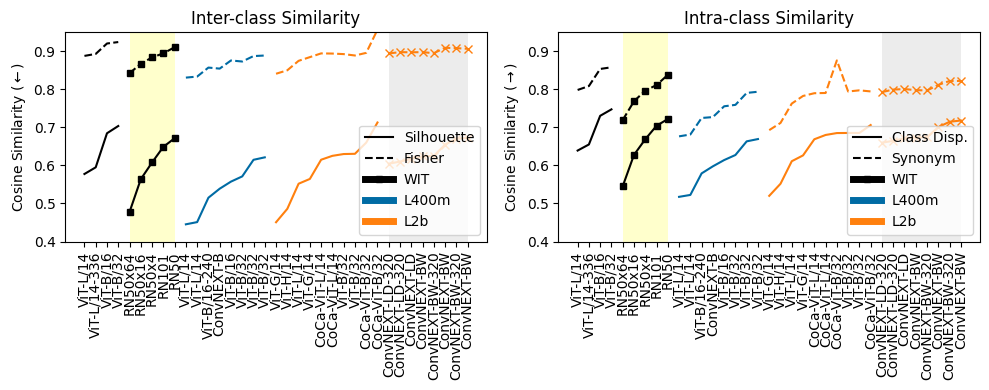

In [6]:
metric_rename={
    'intra_close':'Silhouette score', 
    'inter_close':'Class Dispersion', 
    'intraclass_sim':'Fisher criterion', 
    'superclass_metric':'Synonym Consistency'
}

models = []
order_dict = {v: i for i, v in enumerate(name_order.keys())}
def sort_key(v):
    return [order_dict[vv] for vv in v]

df_openai = df.loc[df.pretrained.isin(['openai'])]

df_openai_RN = df_openai.loc[df_openai.model.isin(['RN50', 'RN50x4', 'RN50x16', 'RN50x64', 'RN101'])].groupby('model_fullname')
df_openai_ViT = df_openai.loc[~df_openai.model.isin(['RN50', 'RN50x4', 'RN50x16', 'RN50x64', 'RN101'])].groupby('model_fullname')

df_400m = df.loc[df.pretrained.isin([d for d in df.pretrained.unique() if 'laion400m' in d])].groupby('model_fullname')
df_2b = df.loc[~df.pretrained.isin([d for d in df.pretrained.unique() if 'laion400m' in d or d=='openai'])]#.groupby('model_fullname')
df_2b_convnext = df_2b.loc[df_2b.model.isin([d for d in df.model.unique() if 'convnext' in d])].groupby('model_fullname')
df_2b_ViT = df_2b.loc[~df_2b.model.isin([d for d in df.model.unique() if 'convnext' in d])].groupby('model_fullname')


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

metric_rename={
    'intra_close':'Silhouette', 
    'inter_close':'Class Disp.', 
    'intraclass_sim':'Fisher', 
    'superclass_metric':'Synonym'
}

colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']
colors = ['k', '#006BA4', '#FF800E', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']

for i, metrics in enumerate([['intra_close', 'intraclass_sim'], ['inter_close', 'superclass_metric']]):
    metric = metrics[0]
    
    tmp_openai_RN_1 = df_openai_RN[metric].mean().sort_values()
    tmp_openai_ViT_1 = df_openai_ViT[metric].mean().sort_values()
    tmp_400m_1 = df_400m[metric].mean().sort_values()
    tmp_2b_1 = df_2b_convnext[metric].mean().sort_values()
    tmp_2b_3 = df_2b_ViT[metric].mean().sort_values()

    ax[i].plot([translation_dict[t] for t in tmp_openai_ViT_1.index], tmp_openai_ViT_1.values, '-', c=colors[0], label=metric_rename[metrics[0]])
    ax[i].plot([], [], '--', c=colors[0], label=metric_rename[metrics[1]])    
    ax[i].plot([translation_dict[t] for t in tmp_openai_RN_1.index], tmp_openai_RN_1.values, '-', c=colors[0], label='WIT', marker='s', markersize=4)
    ax[i].plot([translation_dict[t] for t in tmp_400m_1.index], tmp_400m_1.values, '-', c=colors[1], label='L400m')
    ax[i].plot([translation_dict[t] for t in tmp_2b_3.index], tmp_2b_3.values, '-', label='L2b',c=colors[2])
    ax[i].plot([translation_dict[t] for t in tmp_2b_1.index], tmp_2b_1.values, '-',c=colors[2],  marker='x')

    metric = metrics[1]
    tmp_openai_RN_2 = df_openai_RN[metric].mean()[tmp_openai_RN_1.index]
    tmp_openai_ViT_2 = df_openai_ViT[metric].mean()[tmp_openai_ViT_1.index]
    tmp_400m_2 = df_400m[metric].mean()[tmp_400m_1.index]
    tmp_2b_2 = df_2b_convnext[metric].mean()[tmp_2b_1.index]
    tmp_2b_4 = df_2b_ViT[metric].mean()[tmp_2b_3.index]
    
    ax[i].plot([translation_dict[t] for t in tmp_openai_ViT_2.index], tmp_openai_ViT_2.values, '--', c=colors[0])
    ax[i].plot([translation_dict[t] for t in tmp_openai_RN_2.index], tmp_openai_RN_2.values, '--', c=colors[0],  marker='s', markersize=4)
    ax[i].plot([translation_dict[t] for t in tmp_400m_2.index], tmp_400m_2.values, '--',c=colors[1])
    ax[i].plot([translation_dict[t] for t in tmp_2b_4.index], tmp_2b_4.values, '--',c=colors[2])
    ax[i].plot([translation_dict[t] for t in tmp_2b_2.index], tmp_2b_2.values, '--',c=colors[2],  marker='x')

    tmp = list(tmp_openai_ViT_1.index) +  list(tmp_openai_RN_1.index) + list(tmp_400m_1.index) +  list(tmp_2b_3.index)+  list(tmp_2b_1.index)
    ax[i].set_xticklabels([translation_dict[t].split(',')[0]  for t in tmp], rotation=90)
    ax[i].set_ylabel('Cosine Similarity')
    leg = ax[i].legend(loc='lower right')
    for l in leg.legendHandles[2:]:
        l.set_linewidth(5)
    
ax[0].set_ylabel('Cosine Similarity $(\\leftarrow)$')
ax[1].set_ylabel('Cosine Similarity $(\\rightarrow)$')
ax[0].set_title('Inter-class Similarity')
ax[1].set_title('Intra-class Similarity')
ax[0].set_ylim([0.40, 0.95])
ax[1].set_ylim([0.40, 0.95])
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(wspace=0.17)
ax[0].axvspan(4, 8, ymin=0, ymax=1, facecolor='yellow', alpha=0.2)
ax[0].axvspan(27, 34, ymin=0, ymax=1, facecolor='grey', alpha=0.15)
ax[1].axvspan(4, 8, ymin=0, ymax=1, facecolor='yellow', alpha=0.2)
ax[1].axvspan(27, 34, ymin=0, ymax=1, facecolor='grey', alpha=0.15)
plt.savefig('ModelUnd.pdf', format='pdf', bbox_inches='tight', dpi=300)


Optimized parameters [a, b] are :  [1.95003763e-01 6.86510333e-03 1.56065633e+01]


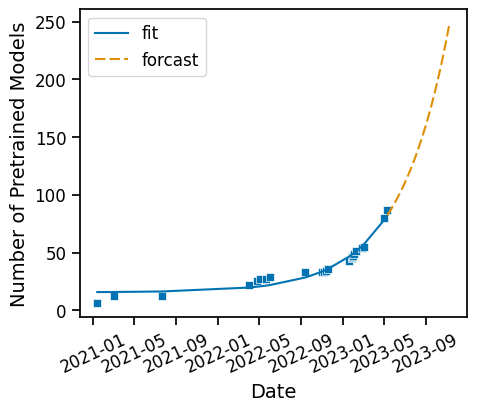

In [7]:
forecast_days = 365//2
sns.set_context("notebook", font_scale=1.1)

df = pd.read_csv('LOVM/openai_num_models.csv')

df['Date'] = pd.to_datetime(df['Date'])
base_date = df['Date'].min()
df['Time'] = (df['Date'] - base_date).dt.days
def func(time, a, b, c):
    return a * np.exp(b * time)+ c
guess = [1, 0.01, 1 ]

popt, pcov = curve_fit(func, df['Time'], df['Number of Pretrained Models'],  p0=guess)
print("Optimized parameters [a, b] are : ", popt)

df['exp_fit'] = func(df['Time'], popt[0], popt[1], popt[2])

last_date = df['Date'].max()
forecast_dates = pd.date_range(start=last_date, periods=forecast_days + 1)  # we start at the day after the last date
forecast_time = (forecast_dates - base_date).days


# Create a DataFrame
df_forecast = pd.DataFrame({
    'Date': pd.to_datetime(forecast_dates),
    'Time': forecast_time
})

# Apply the model to forecast
df_forecast['Forecast'] = func(df_forecast['Time'], popt[0], popt[1], popt[2])


# Set the figure size for a square plot
plt.figure(figsize=(5, 4))

# Plot the data using seaborn
sns.scatterplot(data=df, x="Date", y="Number of Pretrained Models", marker='s')
sns.lineplot(data=df, x="Date", y="exp_fit", label = 'fit')
sns.lineplot(data=df_forecast, x="Date", y="Forecast", dashes=(5, 2), label = 'forcast')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=25)

# Set the x and y-axis labels
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Pretrained Models", fontsize=14)

# Save the plot with DPI 300
plt.savefig("pretrained_models_plot.png", dpi=300)

# Display the plot
plt.show()
